### Upwelled tracer

In this notebook we compare Tr mass and HCW Astoria runs (Astoria, Argo, high Kv 10$^{-2}$ step and epsilon 25)and for all tracers. Then we find the tracer and water upwelling flux ($\Phi$, $\Phi_{Tr}$) and compare it to scaling estimates from Ramos-Musalem and Allen 2019 and Howatt and Allen 2013, respectively.

* HCW all calculated with lin tracer, but shouldn't it be the same for all tracers ideally? Ideally, I think so, but some profiles will be more diffusive (if they concave) and thus, will find less upwelled water. By sticking to the linear profile we guaratee that we are counting tracer mass only on the same pool for water.

* TrMass calculated using lin tracer to find cells with upwelled water and concetration from the tracer we are studying.

OJO: I have converted from umol/kg to uM in the calculation for HCW, TrMass, etc for Oxygen, DIC and Alkalinity. Methane and Nitorus oxide are in nM so they shoul be multiplied by $10^{_3}$.

In [22]:
import cmocean as cmo
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import canyon_tools.readout_tools as rout
import canyon_tools.savitzky_golay as sg
import xarray as xr
import matplotlib.gridspec as gspec

In [23]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [24]:
sns.set_context('notebook')
sns.set_style('whitegrid')

In [25]:
def calc_rho(RhoRef,T,S,alpha=2.0E-4, beta=7.4E-4):
    """-----------------------------------------------------------------------------
    calc_rho calculates the density profile using a linear equation of state.
    
    INPUT:
    state: xarray dataframe
    RhoRef : reference density at the same z as T and S slices. Can be a scalar or a 
             vector, depending on the size of T and S.
    T, S   : should be 1D arrays size nz
    alpha = 2.0E-4 # 1/degC, thermal expansion coefficient
    beta = 7.4E-4, haline expansion coefficient
    OUTPUT:
    rho - Density [nz]
    -----------------------------------------------------------------------------"""
    
    #Linear eq. of state 
    rho = RhoRef*(np.ones(np.shape(T[:])) - alpha*(T[:]) + beta*(S[:]))
    return rho

def call_rho(t,state,zslice,xind,yind):
    T = state.Temp.isel(T=t,Z=zslice,X=xind,Y=yind)
    S = state.S.isel(T=t,Z=zslice,X=xind,Y=yind)
    rho = calc_rho(RhoRef,T,S,alpha=2.0E-4, beta=7.4E-4)
    return(rho) 

def getProfile(ptracers_file, mask, trac, xind, yind, zslice, tt):
    
    with Dataset(ptracers_file, 'r') as nbl:
        
        tr = np.ma.masked_array(nbl.variables[trac][tt,zslice,yind,xind], mask = mask[zslice,yind,xind])
       
    return (tr)

In [26]:
ptr_fileA = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/ptracersGlob.nc'
grid_fileA = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/gridGlob.nc'

ptr_fileANoC = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/02_Ast03_No_Cny/ptracersGlob.nc'
grid_fileANoC = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/02_Ast03_No_Cny/gridGlob.nc'

state_file = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/stateGlob.nc'
state = xr.open_dataset(state_file)
RhoRef = 999.79998779 # It is constant in all my runs, can't run rdmds

In [1]:
nz = 104
sb_Ast = 29 # shelf break z-index Astoria
sb_Bar = 39 # shelf break z-index Barkley

with Dataset(ptr_fileA, 'r') as nbl:
    time = nbl.variables['T'][:]
        
with Dataset(grid_fileA, 'r') as nbl:
    ZA = nbl.variables['RC'][:]
    YA = nbl.variables['Y'][:]
    XA = nbl.variables['X'][:]
    hFacA = nbl.variables['HFacC'][:]
    DepthA = nbl.variables['Depth'][:]
    hfac = np.ma.masked_values(hFacA, 0)
    maskCA = np.ma.getmask(hfac)
    rAA = nbl.variables['rA'][:]
    
with Dataset(grid_fileANoC, 'r') as nbl:
    hFacANoC = nbl.variables['HFacC'][:]
    hfacNoC = np.ma.masked_values(hFacANoC, 0)
    maskCANoC = np.ma.getmask(hfacNoC)
   

NameError: name 'Dataset' is not defined

### 01 - Initial profiles

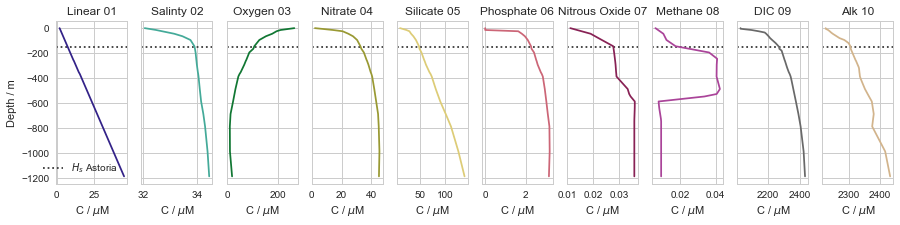

In [28]:
tracers = ['Tr01','Tr02','Tr03','Tr04','Tr05','Tr06','Tr07','Tr08','Tr09','Tr10']
labels = ['Linear 01','Salinty 02','Oxygen 03','Nitrate 04','Silicate 05','Phosphate 06','Nitrous Oxide 07','Methane 08',
         'DIC 09', 'Alk 10']
#colours = ['purple','blue','green','gold','orange','red','orchid','teal']
colours = ['#332288','#44AA99','#117733','#999933','#DDCC77','#CC6677','#882255','#AA4499', 'dimgray', 'tan']
fig,ax = plt.subplots(1,len(tracers),figsize=(15,3), sharey = True)
    
for ii, trac, col, lab in zip(range(len(tracers)),tracers , colours, labels):

    ax[ii].axhline(-150, linestyle=':', color='0.2', label='$H_s$ Astoria')
    
    for pfile, Z, style in zip([ptr_fileA],[ZA],['-']):
        with Dataset(pfile, 'r') as nbl:
        
            if (trac == 'Tr07' or trac == 'Tr08'):
                tr_profile = nbl.variables[trac][0,:,10,180]
                ax[ii].plot(1E-3*tr_profile, Z, color=col,linestyle=style)
                ax[ii].set_xlabel(r'C / $\mu$M')
            
            elif (trac == 'Tr03' or (trac == 'Tr09' or trac == 'Tr10')):
                tr_profile = nbl.variables[trac][0,:,10,180]
                density = call_rho(0,state,slice(0,104),180,20)
                ax[ii].plot(density*tr_profile/1000, Z, color=col,linestyle=style)
                ax[ii].set_xlabel(r'C / $\mu$M')
            
            else:
                ax[ii].set_xlabel(r'C / $\mu$M')
                tr_profile = nbl.variables[trac][0,:,10,180]
                ax[ii].plot(tr_profile, Z, color=col,linestyle=style)

        ax[ii].set_title(lab)
        
        
ax[0].set_ylabel('Depth / m')        
ax[0].legend(loc=0)

#### Vertical tracer gradient

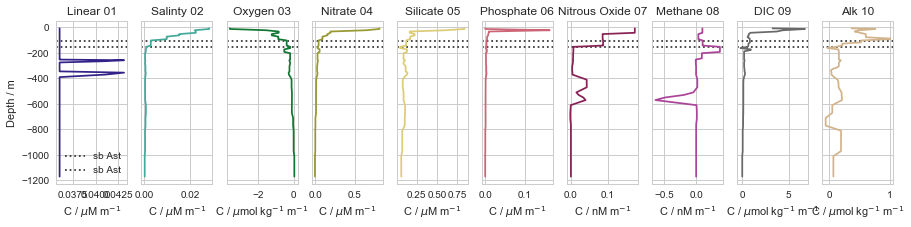

In [29]:
dTr_Ast = np.empty(len(tracers))
Tr_Ast = np.empty(len(tracers))

fig,ax = plt.subplots(1,len(tracers),figsize=(15,3), sharey = True)
    
for ii, trac, col, lab in zip(range(len(tracers)),tracers , colours, labels):

    ax[ii].axhline(-150, linestyle=':', color='0.2', label='sb Ast')
    ax[ii].axhline(-110, linestyle=':', color='0.2', label='sb Ast')
    
    for pfile, Z, style in zip([ptr_fileA],[ZA],['-']):
        
        with Dataset(pfile, 'r') as nbl:
            tr_profile = nbl.variables[trac][0,:,10,180]
            dTrdz = (tr_profile[2:]-tr_profile[:-2])/(-Z[2:]+Z[:-2])  
            dTr_Ast[ii] = dTrdz[sb_Ast+1]/dTrdz[sb_Ast-1]
            Tr_Ast[ii] = tr_profile[sb_Ast]
            
        ax[ii].plot(dTrdz, Z[1:-1], color=col,linestyle=style)
        ax[ii].set_title(lab)
        
        if (trac == 'Tr07' or trac == 'Tr08'):
            ax[ii].set_xlabel('C / nM m$^{-1}$')
        elif (trac == 'Tr03' or (trac == 'Tr09' or trac == 'Tr10')):
            ax[ii].set_xlabel('C / $\mu$mol kg$^{-1}$ m$^{-1}$')
        else:
            ax[ii].set_xlabel(r'C / $\mu$M m$^{-1}$')

ax[0].set_ylabel('Depth / m')        
ax[0].legend(loc=0)

Get initial concentration at shelf break

In [70]:
sb_Ast =  31# 29 shelf break z-index Astoria

ptr_fileA = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/ptracersGlob.nc'

tracers_C = ['Tr01','Tr02','Tr03','Tr04','Tr05','Tr06','Tr07','Tr08','Tr09','Tr10']
labels_C = ['Linear 01','Salinty 02','Oxygen 03','Nitrate 04','Silicate 05','Phosphate 06','Nitrous Oxide 07','Methane 08',
         'DIC 09', 'Alk 10']

sb_conc_A = np.empty(len(labels))

for ii, trac in zip(range(len(tracers_C)),tracers_C):
    for pfile,sb_array, sb_ind in zip([ptr_fileA],[sb_conc_A], [sb_Ast]):
        with Dataset(pfile, 'r') as nbl:
            
            if (trac == 'Tr07' or trac == 'Tr08'):
                tr_profile = 1E-3*nbl.variables[trac][0,:,10,180]
                sb_array[ii] = tr_profile[sb_ind]
                
            elif (trac == 'Tr03' or (trac == 'Tr09' or trac == 'Tr10')):
                tr_profile = density*nbl.variables[trac][0,:,10,180]/1000
                density = call_rho(0,state,slice(0,104),180,20)
                sb_array[ii] = tr_profile[sb_ind]

            else:
                tr_profile = nbl.variables[trac][0,:,10,180]
                sb_array[ii] = tr_profile[sb_ind]

### 02 - HCW



Canyon runs, using linear tracer. Plotting only two tracers but all tracers give the same lines.

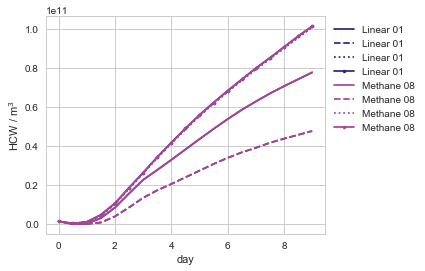

In [71]:
fig, ax = plt.subplots(1,1,figsize=(5,4), sharey=True)

tracers2 = ['Tr01','Tr08']
labels2 = ['Linear 01','Methane 08','DIC 09', 'Alk 10']
colours2 = ['#332288','#AA4499']

for key, col, lab in zip(tracers2, colours2, labels2):
    
    f_Ast = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_01.csv' %key)
    df_Ast = pd.read_csv(f_Ast)
    HCW_Ast = df_Ast['HCW']
    f_Ast3 = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_03.csv' %key)
    df_Ast3 = pd.read_csv(f_Ast3)
    HCW_Ast3 = df_Ast3['HCW']
    f_AstKv = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_KV3D_AST/HCW_TrMass_%s_UPW_10TR_BF2_KV3D_AST_01.csv' %key)
    df_AstKv = pd.read_csv(f_AstKv)
    HCW_AstKv = df_AstKv['HCW']
    f_AstKv2 = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_KV3D_AST/HCW_TrMass_%s_UPW_10TR_BF2_KV3D_AST_02.csv' %key)
    df_AstKv2 = pd.read_csv(f_AstKv2)
    HCW_AstKv2 = df_AstKv2['HCW']
    
    ax.plot(np.arange(19)/2, HCW_Ast, color=col, label=lab)
    ax.plot(np.arange(19)/2, HCW_Ast3,'--', color=col, label=lab)
    ax.plot(np.arange(19)/2, HCW_AstKv,':', color=col, label=lab)
    ax.plot(np.arange(19)/2, HCW_AstKv2,'.-', color=col, label=lab)
    
ax.set_ylabel('HCW / m$^3$')
ax.set_xlabel('day')

ax.legend(bbox_to_anchor=(1,1))

### 03. Upwelled Tracer 

Unit conversion:

$\mu$M m$^3$ = $\mu$mol L$^{-1}$ m$^3$ = $\mu$mol L$^{-1}$ $10^{3}$L  = 1000 $\mu$mol 

So, multiply all TrMass by 1000 except methane and nitrous oxide that should be multiplied by $10^{-3}$x1000=1 (nM to $\mu$M and then to $\mu$mol/s)

**Canyon runs**

uM
uM
uM
uM
uM
uM
nM to uM
nM to uM
uM
uM


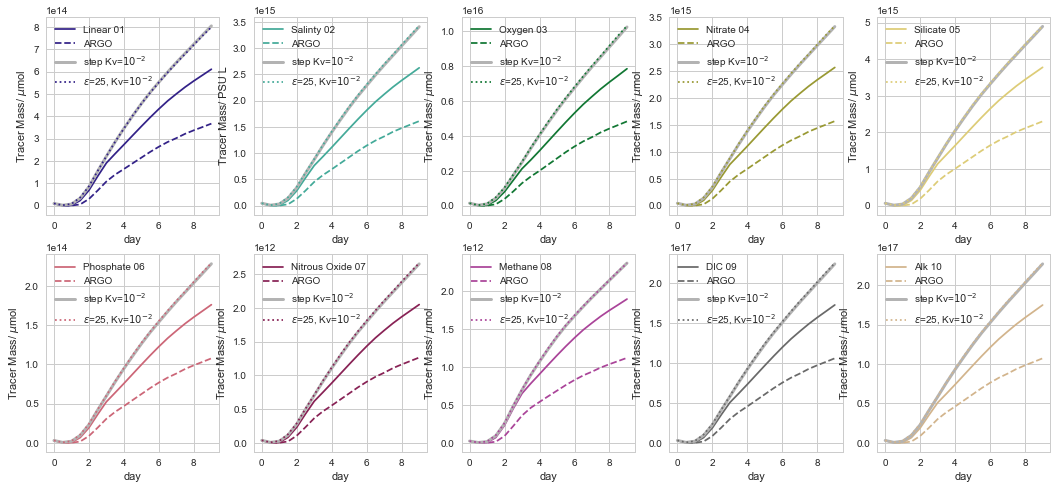

In [72]:
fig, ((ax0,ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8,ax9)) = plt.subplots(2,5,figsize=(18,8))

axes = [ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]

for key, col, lab, ax in zip(tracers, colours, labels, axes):
    
    f_Ast = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_01.csv' %key)
    f_Argo = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_03.csv' %key)
    f_KV1 = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_KV3D_AST/HCW_TrMass_%s_UPW_10TR_BF2_KV3D_AST_01.csv' %key)
    f_KV2 = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_KV3D_AST/HCW_TrMass_%s_UPW_10TR_BF2_KV3D_AST_02.csv' %key)
    
    df_Ast = pd.read_csv(f_Ast)
    df_Argo = pd.read_csv(f_Argo)
    df_KV1 = pd.read_csv(f_KV1)
    df_KV2 = pd.read_csv(f_KV2)
    
    if (key == 'Tr07' or key == 'Tr08'): # nM to uM
        TrMass_Ast = df_Ast['TrMassHCW'] 
        TrMass_Argo = df_Argo['TrMassHCW']
        TrMass_KV1 = df_KV1['TrMassHCW']
        TrMass_KV2 = df_KV2['TrMassHCW']
        print('nM to uM')
    else:
        TrMass_Ast = df_Ast['TrMassHCW']*1E3
        TrMass_Argo = df_Argo['TrMassHCW']*1E3
        TrMass_KV1 = df_KV1['TrMassHCW']*1E3
        TrMass_KV2 = df_KV2['TrMassHCW']*1E3
        print('uM')
    
    ax.plot(np.arange(19)/2, TrMass_Ast, color=col, label=lab)
    ax.plot(np.arange(19)/2, TrMass_Argo,'--', color=col, label='ARGO')
    ax.plot(np.arange(19)/2, TrMass_KV1,'-', color='0.7', label=r'step Kv=$10^{-2}$', linewidth=3)
    ax.plot(np.arange(19)/2, TrMass_KV2,':', color=col, label=r'$\epsilon$=25, Kv=$10^{-2}$')
    ax.legend()
    if (key == 'Tr02'):
        ax.set_ylabel(r'Tracer Mass/ PSU L')
    else:
        ax.set_ylabel(r'Tracer Mass/ $\mu$mol')
        
    ax.set_xlabel('day')



**No canyon**

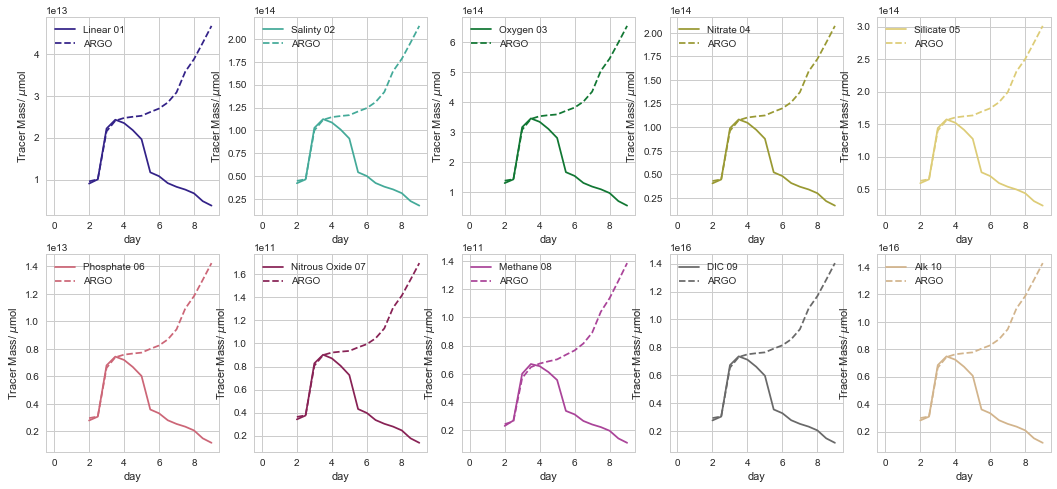

In [73]:
fig, ((ax0,ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8,ax9)) = plt.subplots(2,5,figsize=(18,8))
axes = [ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]

for key, col, lab, ax in zip(tracers, colours, labels,  axes):
    
    f_Ast = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_02.csv' %key)
    f_Argo = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_04.csv' %key)
    df_Ast = pd.read_csv(f_Ast)
    df_Argo = pd.read_csv(f_Argo)
    
    if (key == 'Tr07' or key == 'Tr08'):
        TrMass_Ast = df_Ast['TrMassHCW']
        TrMass_Argo = df_Argo['TrMassHCW']
    else:
        TrMass_Ast = df_Ast['TrMassHCW']*1E3
        TrMass_Argo = df_Argo['TrMassHCW']*1E3
    
    ax.plot(np.arange(19)/2, TrMass_Ast, color=col, label=lab)
    ax.plot(np.arange(19)/2, TrMass_Argo,'--', color=col, label='ARGO')
    ax.legend()
    ax.set_ylabel(r'Tracer Mass/ $\mu$mol ')
    ax.set_xlabel('day')



**Canyon effect** (Can - no Can runs)

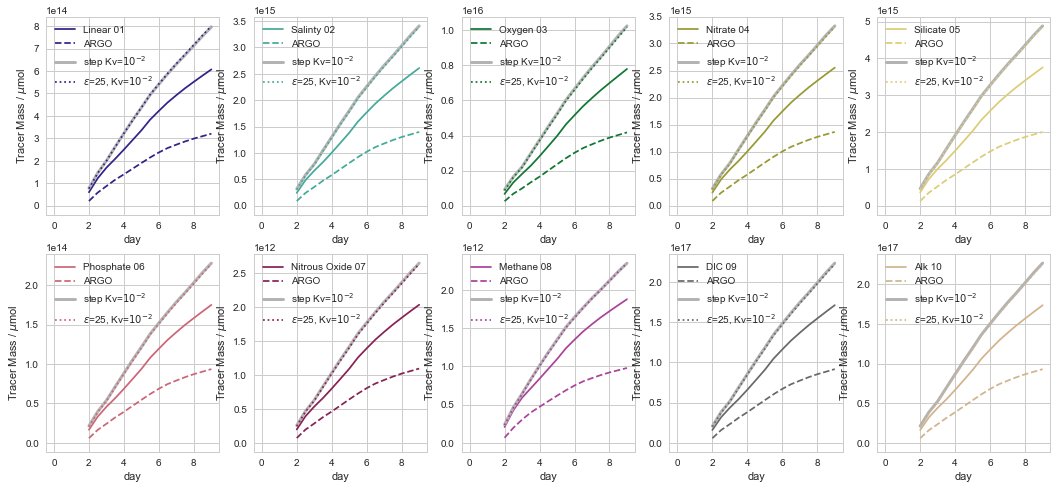

In [74]:
fig, ((ax0,ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8,ax9)) = plt.subplots(2,5,figsize=(18,8))
axes = [ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]

for key, col, lab, ax in zip(tracers, colours, labels, axes):
    
    f_Ast = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_01.csv' %key)
    f_KV1 = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_KV3D_AST/HCW_TrMass_%s_UPW_10TR_BF2_KV3D_AST_01.csv' %key)
    f_KV2 = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_KV3D_AST/HCW_TrMass_%s_UPW_10TR_BF2_KV3D_AST_02.csv' %key)
    f_AstNoC = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_02.csv' %key)
    f_Argo = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_03.csv' %key)
    f_ArgoNoC = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_04.csv' %key)
    
    df_Ast = pd.read_csv(f_Ast)
    df_Argo = pd.read_csv(f_Argo)
    df_AstNoC = pd.read_csv(f_AstNoC)
    df_ArgoNoC = pd.read_csv(f_ArgoNoC)
    df_KV1 = pd.read_csv(f_KV2)
    df_KV2 = pd.read_csv(f_KV1)
    
    if (key == 'Tr07' or key == 'Tr08'):
        TrMass_Ast = df_Ast['TrMassHCW']
        TrMass_Argo = df_Argo['TrMassHCW']
        TrMass_KV1 = df_KV1['TrMassHCW']
        TrMass_KV2 = df_KV2['TrMassHCW']
        TrMass_AstNoC = df_AstNoC['TrMassHCW']
        TrMass_ArgoNoC = df_ArgoNoC['TrMassHCW']
    else:
        TrMass_Ast = df_Ast['TrMassHCW']*1E3
        TrMass_Argo = df_Argo['TrMassHCW']*1E3
        TrMass_KV1 = df_KV1['TrMassHCW']*1E3
        TrMass_KV2 = df_KV2['TrMassHCW']*1E3
        TrMass_AstNoC = df_AstNoC['TrMassHCW']*1E3
        TrMass_ArgoNoC = df_ArgoNoC['TrMassHCW']*1E3

    ax.plot(np.arange(19)/2, TrMass_Ast-TrMass_AstNoC, color=col, label=lab)
    ax.plot(np.arange(19)/2, TrMass_Argo-TrMass_ArgoNoC,'--', color=col, label='ARGO')
    ax.plot(np.arange(19)/2, TrMass_KV1-TrMass_AstNoC,'-', color='0.7', label=r'step Kv=$10^{-2}$', linewidth=3)
    ax.plot(np.arange(19)/2, TrMass_KV2-TrMass_AstNoC,':', color=col, label=r'$\epsilon$=25, Kv=$10^{-2}$')
    ax.legend()
    ax.set_ylabel(r'Tracer Mass / $\mu$mol')
    ax.set_xlabel('day')



### 4. Tracer flux 

vs upwelling flux $\times$ C$_{sb}$ (all from model output)

Unit conversion:

$\mu$M m$^3$s$^{-1}$ = $\mu$mol L$^{-1}$ m$^3$s$^{-1}$ = $\mu$mol L$^{-1}$ $10^{3}$L s$^{-1}$ = 1000 $\mu$mol s$^{-1}$ 

So, multiply all TrMass by 1000 except methane and nitrous oxide that should be multiplied by $10^{-3}$x1000=1 (nM to $\mu$M and then to $\mu$mol/s)

Linear 01, error -0.133 percent 
Linear 01 ARGO, error 0.934 percent 
Linear 01 KV1 error -2.616 percent 
Linear 01 KV2 error -1.379 percent 
Salinty 02, error 0.205 percent 
Salinty 02 ARGO, error 0.163 percent 
Salinty 02 KV1 error 0.191 percent 
Salinty 02 KV2 error 0.191 percent 
Oxygen 03, error -0.096 percent 
Oxygen 03 ARGO, error 0.200 percent 
Oxygen 03 KV1 error 0.458 percent 
Oxygen 03 KV2 error 0.238 percent 
Nitrate 04, error 0.543 percent 
Nitrate 04 ARGO, error 0.525 percent 
Nitrate 04 KV1 error 0.338 percent 
Nitrate 04 KV2 error 0.435 percent 
Silicate 05, error 0.598 percent 
Silicate 05 ARGO, error 0.747 percent 
Silicate 05 KV1 error 0.111 percent 
Silicate 05 KV2 error 0.329 percent 
Phosphate 06, error 0.470 percent 
Phosphate 06 ARGO, error 0.510 percent 
Phosphate 06 KV1 error 0.256 percent 
Phosphate 06 KV2 error 0.359 percent 
Nitrous Oxide 07, error 6.614 percent 
Nitrous Oxide 07 ARGO, error 5.781 percent 
Nitrous Oxide 07 KV1 error 6.643 percent 
Nitrous O

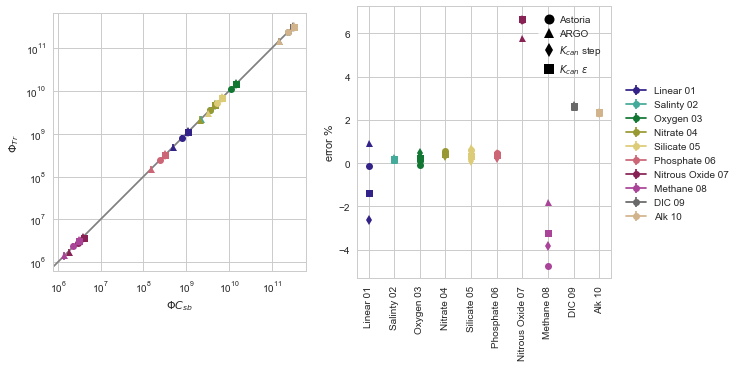

In [75]:
fig, (ax,ax2) = plt.subplots(1,2,figsize=(10,5))
xx = np.linspace(0,3.5E11, 20)
ax.plot(xx,xx,'-', color='0.5')

ii=0
for key, col, lab, C in zip(tracers, colours, labels, sb_conc_A):
    
    filename = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_01.csv' %key)
    df = pd.read_csv(filename)
    HCW = 1000*df['HCW'][:] # *1000 to go from m^3/s to L/s
    
    filenameKV1 = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_KV3D_AST/HCW_TrMass_%s_UPW_10TR_BF2_KV3D_AST_01.csv' %key)
    dfKV1 = pd.read_csv(filenameKV1)
    HCWKV1 = 1000*dfKV1['HCW'][:] # *1000 to go from m^3/s to L/s
    
    filenameKV2 = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_KV3D_AST/HCW_TrMass_%s_UPW_10TR_BF2_KV3D_AST_02.csv' %key)
    dfKV2 = pd.read_csv(filenameKV2)
    HCWKV2 = 1000*dfKV2['HCW'][:] # *1000 to go from m^3/s to L/s
    
    filenameARGO = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_03.csv' %key)
    dfARGO = pd.read_csv(filenameARGO)
    HCWARGO = 1000*dfARGO['HCW'][:] # *1000 to go from m^3/s to L/s
    
    if (key == 'Tr07' or key == 'Tr08'):
        TrMass = df['TrMassHCW'][:]
        TrMassARGO = dfARGO['TrMassHCW'][:]
        TrMassKV1 = dfKV1['TrMassHCW'][:]
        TrMassKV2 = dfKV2['TrMassHCW'][:]
    else:
        TrMass = df['TrMassHCW'][:]*1E3
        TrMassARGO = dfARGO['TrMassHCW'][:]*1E3
        TrMassKV1 =  dfKV1['TrMassHCW'][:]*1E3
        TrMassKV2 =  dfKV2['TrMassHCW'][:]*1E3
    
    Phi = np.mean(np.array([(HCW[ii]-HCW[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    Phi_std = np.std(np.array([(HCW[ii]-HCW[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    PhiTr = np.mean(np.array([(TrMass[ii]-TrMass[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    PhiTr_std = np.std(np.array([(TrMass[ii]-TrMass[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    
    PhiKV1 = np.mean(np.array([(HCWKV1[ii]-HCWKV1[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    Phi_stdKV1 = np.std(np.array([(HCWKV1[ii]-HCWKV1[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    PhiTrKV1 = np.mean(np.array([(TrMassKV1[ii]-TrMassKV1[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    PhiTr_stdKV1 = np.std(np.array([(TrMassKV1[ii]-TrMassKV1[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
   
    PhiKV2 = np.mean(np.array([(HCWKV2[ii]-HCWKV2[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    Phi_stdKV2 = np.std(np.array([(HCWKV2[ii]-HCWKV2[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    PhiTrKV2 = np.mean(np.array([(TrMassKV2[ii]-TrMassKV2[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    PhiTr_stdKV2 = np.std(np.array([(TrMassKV2[ii]-TrMassKV2[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
   
    PhiARGO = np.mean(np.array([(HCWARGO[ii]-HCWARGO[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    Phi_stdARGO = np.std(np.array([(HCWARGO[ii]-HCWARGO[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    PhiTrARGO = np.mean(np.array([(TrMassARGO[ii]-TrMassARGO[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    PhiTr_stdARGO = np.std(np.array([(TrMassARGO[ii]-TrMassARGO[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    
    error = 100*(Phi*C-PhiTr)/PhiTr
    errorARGO = 100*(PhiARGO*C-PhiTrARGO)/PhiTrARGO
    errorKV1 = 100*(PhiKV1*C-PhiTrKV1)/PhiTrKV1
    errorKV2 = 100*(PhiKV2*C-PhiTrKV2)/PhiTrKV2
    
    ax.errorbar(Phi*C, PhiTr, yerr=PhiTr_std, marker='o', c=col, label=lab)
    ax2.errorbar(ii,error, marker='o', c=col, label=lab)
     
    ax.errorbar(PhiARGO*C, PhiTrARGO, yerr=PhiTr_stdARGO, marker='^', c=col)
    ax2.errorbar(ii,errorARGO,  marker='^', c=col, label='ARGO')
    
    ax.errorbar(PhiKV1*C, PhiTrKV1, yerr=PhiTr_stdKV1, marker='d', c=col)
    ax2.errorbar(ii,errorKV1,  marker='d', c=col, label='KV1')
    
    ax.errorbar(PhiKV2*C, PhiTrKV2, yerr=PhiTr_stdKV2, marker='s', c=col)
    ax2.errorbar(ii,errorKV2, marker='s', c=col, label='KV2')
    
    print('%s, error %1.3f percent ' %(lab, error))
    print('%s ARGO, error %1.3f percent ' %(lab, errorARGO))
    print('%s KV1 error %1.3f percent ' %(lab, errorKV1))
    print('%s KV2 error %1.3f percent ' %(lab, errorKV2))
    ii = ii+1

legend_elements = [Line2D([0], [0], marker='o',color='w', label='Astoria',
                          markerfacecolor='k', mec='k',markersize=10),
                   Line2D([0], [0], marker='^',color='w', label='ARGO',
                          markerfacecolor='k', mec='k',markersize=10),
                   Line2D([0], [0], marker='d',color='w', label=r'$K_{can}$ step',
                          markerfacecolor='k', mec='k',markersize=10),
                   Line2D([0], [0], marker='s',color='w', label=r'$K_{can}$ $\epsilon$',
                          markerfacecolor='k', mec='k',markersize=10),
                   ]


ax2.legend(handles=legend_elements, bbox_to_anchor=(1,1), handletextpad=0)
ax.legend(bbox_to_anchor=(2.7,0.75), ncol=1)

ax.set_ylabel(r'$\Phi_{Tr}$')
ax.set_xlabel(r'$\Phi C_{sb}$')
ax2.set_ylabel(r'error $\%$')
ax.set_aspect(1)
ax.set_yscale('log')
ax.set_xscale('log')
ax2.set_xticks([0,1,2,3,4,5,6,7,8,9])
ax2.set_xticklabels(labels,rotation=90)

print('Phi Astoria from model is %f' %Phi)
print('Phi ARGO from model is %f' %PhiARGO)
print('Phi KV1from model is %f' %PhiKV1)
print('Phi KV2 from model is %f' %PhiKV2)

It is reasonable to scale tracer flux $\Phi_{Tr}$ as upwelling flux $\Phi C_{sb}$ within 0.5% except for Linear (5%-7%) and Methane ($\sim$22%) and nitrous oxide ($\sim$6%). All errors smaller than the standard deviation of PhiTr. If I use C at Z[31] instead of Z[29] error in Methane reduces to between -2 to -4.5%, linear to -2.5 to 1% and nitrous oxide between 6 and 7%

### 5. Comparison to previous scalings

In [76]:
def Dh(f,L,N):
    '''Vertical scale Dh'''
    return((f*L)/(N))
    
def Ro(U,f,R):
    '''Rossby number'''
    return(U/(f*R))

def F(Ro):
    '''Function that estimates the ability of the flow to follow isobaths'''
    return(Ro/(0.9+Ro))

def Bu(N,f,W,Hs):
    '''Burger number'''
    return((N*Hs)/(f*W))

def RossbyRad(N,Hs,f):
    '''1st Rossby radius of deformation'''
    return((N*Hs)/f)

def SE(s,N,f,Fw,Rl):
    '''Slope effect '''
    return((s*N)/(f*(Fw/Rl)**0.5))

In [107]:
g = 9.81 # accel. gravity
Hs = 152.5 # Shelf break depth
s = 0.00230 # shelf slope 
N = np.array([5.5E-3,9.9E-3,5.5E-3,5.5E-3,])
f = np.array([1.0E-4,1.05E-4,1E-4,1E-4])
U = np.array([0.3,0.329,0.269,0.268]) 
Wiso = 8900
L = 21800
nz = 104
ny = 360
nx = 616
epsilons = np.array([5,5,5,25])    
Hrim = 120
Hh = 97.5
t = 6.5
R = 4500
kcans = np.array([1E-5,1E-5,1E-2,1E-2])
kbgs = np.array([1E-5,1E-5,1E-5,1E-5])

#H&A 2013
slope = 0.91 
param = 1.21
intercept = 0.07

#RM&A2019
slope2 = 5
param2 = 0.86
intercept2 = -0.01

In [108]:
# From cell in 4, change from L to m^3
Phi_model = np.array([107397145.564757/1000,65720852.621222/1000,142320434.434855/1000,143154869.108308/1000])
run_labels=['Ast', 'ARGO','KV1','KV2']

for uu, nn, ff, phi, run_lab in zip(U,N,f,Phi_model, run_labels):
    Se = SE(s, nn, ff, F(Ro(uu,ff,Wiso)), Ro(uu,ff,L))
    HA2013=((slope*(F(Ro(uu,ff,Wiso))**(3/2))*(Ro(uu,ff,L)**(1/2))*((1-param*Se)**3))+intercept)*(uu*Wiso*Dh(ff,L,nn))
    print(' %s Phi_HA2013 = %1.3e m^3/s, Phi_model=%1.3e m^3/s, error %1.2f percent' %(run_lab,HA2013, phi, 
                                                                                       (100*(HA2013-phi)/phi)))

 Ast Phi_HA2013 = 1.101e+05 m^3/s, Phi_model=1.074e+05 m^3/s, error 2.47 percent
 ARGO Phi_HA2013 = 6.606e+04 m^3/s, Phi_model=6.572e+04 m^3/s, error 0.52 percent
 KV1 Phi_HA2013 = 9.363e+04 m^3/s, Phi_model=1.423e+05 m^3/s, error -34.21 percent
 KV2 Phi_HA2013 = 9.313e+04 m^3/s, Phi_model=1.432e+05 m^3/s, error -34.95 percent


HA2013 works very well for Astoria. The error of about 22% is consistent with our findings form RA2019 for runs with enhanced diffusivity. Would the error be reduced if we use the effective N from RA2019?

In [113]:
# From cell in 4, change from L to m^3
Phi_model = np.array([107397145.564757/1000,65720852.621222/1000,142320434.434855/1000,143154869.108308/1000])
run_labels=['Ast', 'ARGO','KV1','KV2']


for uu, nn, ff, phi, kcan, kbg,epsilon, run_lab in zip(U,N,f,Phi_model,kcans,kbgs,epsilons, run_labels):
    
    Zdif = ((kcan-kbg)*t*3600*24)**0.5
    dk =(kcan-kbg)

    Dz = 5 #abs(ZA[int(Hrim/5)+1]-ZA[int(Hrim/5)-1])
    Z = ((ff*uu*F(Ro(uu,ff,Wiso))*L)**(0.5))/nn
    Sdif_min = np.exp(-0.15*Zdif/5)
    Sdif_max = (Zdif/Dz)*np.exp(-(kcan*t*3600*24)/((epsilon)**2))
    S_max = (Z/Hh)*np.exp(-kcan*t*3600*24/Z**2)
    S_min = (Z/Hh)*np.exp(-kbg*t*3600*24/Z**2)

    c_be_0 = 2.72 
    c_be_1 = 2.19
    c_be_2 =-1.13

    c_ab_0 = 7.35
    c_ab_1 = 0.21
    c_ab_2 = 0.82

    Nbe_scaled =  np.sqrt(c_be_0*S_min +c_be_1*(1-Sdif_min) +c_be_2)*nn
    Nab_scaled =  np.sqrt(c_ab_0*S_max + c_ab_1*Sdif_max + c_ab_2)*nn

    if  (c_be_0*S_min +c_be_1*(1-Sdif_min) +c_be_2)< 0 :
        N_eff_scaled = (0.75*Nab_scaled)
    else:
        N_eff_scaled = (0.75*Nab_scaled + 0.25*Nbe_scaled) 

    Se = SE(s, nn, ff, F(Ro(uu,ff,Wiso)), Ro(uu,ff,L))
    HA2013=((slope*(F(Ro(uu,ff,Wiso))**(3/2))*(Ro(uu,ff,L)**(1/2))*((1-param*Se)**3))+intercept)*(uu*Wiso*Dh(ff,L,nn))
    RA2019 = (((slope2*(F(Ro(uu,ff,Wiso))**(3/2))*(Ro(uu,ff,L)**(1/2))*((1-param2*Se)**3))+intercept2)*
              (uu*Wiso*Dh(ff,L,N_eff_scaled)))

    print('Phi_HA2013 = %1.3e m^3/s, Phi_model=%1.3e m^3/s, error %1.2f percent' %(HA2013, phi, 100*(HA2013-phi)/phi))
    print('Phi_RA2019 = %1.3e m^3/s, Phi_model=%1.3e m^3/s, error %1.2f percent' %(RA2019, phi, 100*(RA2019-phi)/phi))

Phi_HA2013 = 1.101e+05 m^3/s, Phi_model=1.074e+05 m^3/s, error 2.47 percent
Phi_RA2019 = 9.584e+04 m^3/s, Phi_model=1.074e+05 m^3/s, error -10.76 percent
Phi_HA2013 = 6.606e+04 m^3/s, Phi_model=6.572e+04 m^3/s, error 0.52 percent
Phi_RA2019 = 7.100e+04 m^3/s, Phi_model=6.572e+04 m^3/s, error 8.04 percent
Phi_HA2013 = 9.363e+04 m^3/s, Phi_model=1.423e+05 m^3/s, error -34.21 percent
Phi_RA2019 = 9.770e+04 m^3/s, Phi_model=1.423e+05 m^3/s, error -31.35 percent
Phi_HA2013 = 9.313e+04 m^3/s, Phi_model=1.432e+05 m^3/s, error -34.95 percent
Phi_RA2019 = 9.701e+04 m^3/s, Phi_model=1.432e+05 m^3/s, error -32.24 percent


RA2019 may work if constants are rescaled...

RMSE 1 for Ast is 4.199675e+10 
RMSE 2 for Ast is 2.044366e+10 
RMSE 3 for Ast is 5.399214e+09 
RMSE 4 for Ast is 1.965401e+10 
RMSE 1 for ARGO is 1.521370e+10 
RMSE 2 for ARGO is 1.870984e+10 
RMSE 3 for ARGO is 1.969064e+09 
RMSE 4 for ARGO is 1.535607e+09 
RMSE 1 for KV1 is 3.255896e+10 
RMSE 2 for KV1 is 3.950941e+10 
RMSE 3 for KV1 is 4.638624e+10 
RMSE 4 for KV1 is 6.063463e+10 
RMSE 1 for KV2 is 3.406369e+10 
RMSE 2 for KV2 is 4.118804e+10 
RMSE 3 for KV2 is 4.772649e+10 
RMSE 4 for KV2 is 6.207048e+10 


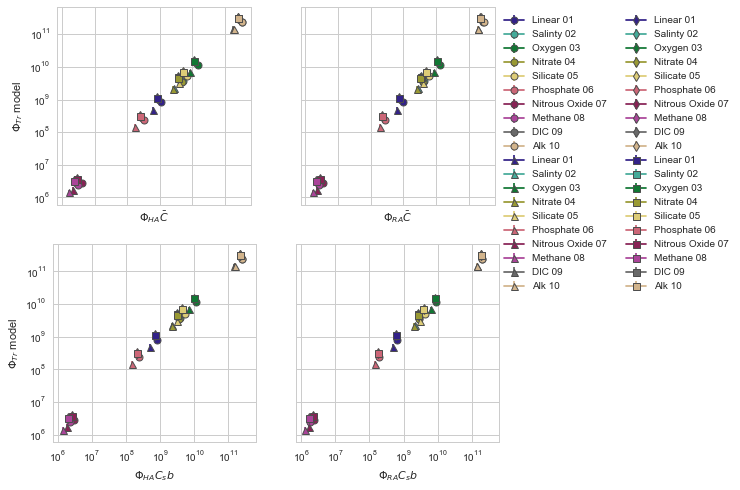

In [114]:
fig, ((ax,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(8,8), sharex=True, sharey=True)

exp_folders = ['UPW_10TR_BF2_AST','UPW_10TR_BF2_AST','UPW_10TR_BF2_KV3D_AST','UPW_10TR_BF2_KV3D_AST']
exps = ['UPW_10TR_BF2_AST_01','UPW_10TR_BF2_AST_03','UPW_10TR_BF2_KV3D_AST_01','UPW_10TR_BF2_KV3D_AST_02']
markers=['o','^','d','s']

for uu, nn, ff, phi, kcan, kbg, epsilon, run_lab, fold, exp, mark in zip(U, N, f, Phi_model, kcans, kbgs, epsilons,
                                                                         run_labels, exp_folders, exps, markers):
    mse_1 = np.zeros(len(tracers))
    mse_2 = np.zeros(len(tracers))
    mse_3 = np.zeros(len(tracers))
    mse_4 = np.zeros(len(tracers))
    ii = 0
    for key, col, lab, C in zip(tracers, colours, labels, sb_conc_A):
    
        # --- get Phi_tr ----
        filename = ('/data/kramosmu/results/TracerExperiments/%s/HCW_TrMass_%s_%s.csv' %(fold,key,exp))
        df = pd.read_csv(filename)
        HCW = 1000*df['HCW'][:] # *1000 to go from m^3/s to L/s

        if (key == 'Tr07' or key == 'Tr08'):
            TrMass = df['TrMassHCW'][:]
        else:
            TrMass = df['TrMassHCW'][:]*1E3

        PhiTr = np.mean(np.array([(TrMass[ii]-TrMass[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
        PhiTr_std = np.std(np.array([(TrMass[ii]-TrMass[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
        # --- ---------- ----

        # --- calculate \bar{C} ----------
        Zdif = ((kcan-kbg)*t*3600*24)**0.5
        dk =(kcan-kbg)

        Dz = 5 #abs(ZA[int(Hrim/5)+1]-ZA[int(Hrim/5)-1])
        Z = ((ff*uu*F(Ro(uu,ff,R))*L)**(0.5))/nn

        Sdif_min = np.exp(-0.15*Zdif/5)
        Sdif_max = (Zdif/Dz)*np.exp(-(kcan*t*3600*24)/((epsilon)**2))
        S_max = (Z/Hh)*np.exp(-kcan*t*3600*24/Z**2)
        S_min = (Z/Hh)*np.exp(-kbg*t*3600*24/Z**2)

        A_4 = 0.33
        B_4 = 0.06
        C_4 = 1.00

        c_be_0 = 2.72
        c_be_1 = 2.19
        c_be_2 =-1.13

        c_ab_0 = 7.35
        c_ab_1 = 0.21
        c_ab_2 = 0.82

        C_bar = (A_4*S_max+B_4*Sdif_max+C_4)*C
        Nbe_scaled =  np.sqrt(c_be_0*S_min +c_be_1*(1-Sdif_min) +c_be_2)*nn
        Nab_scaled =  np.sqrt(c_ab_0*S_max + c_ab_1*Sdif_max + c_ab_2)*nn

        if  (c_be_0*S_min +c_be_1*(1-Sdif_min) +c_be_2)< 0 :
            N_eff_scaled = (0.75*Nab_scaled)
        else:
            N_eff_scaled = (0.75*Nab_scaled + 0.25*Nbe_scaled) 

        Se = SE(s, nn, ff, F(Ro(uu,ff,Wiso)), Ro(uu,ff,L))
        HA2013=1000*((slope*(F(Ro(uu,ff,Wiso))**(3/2))*(Ro(uu,ff,L)**(1/2))*((1-param*Se)**3))+intercept)*(uu*Wiso*Dh(ff,L,nn))
        RA2019 = 1000*(((slope2*(F(Ro(uu,ff,Wiso))**(3/2))*(Ro(uu,ff,L)**(1/2))*((1-param2*Se)**3))+intercept2)*
                       (uu*Wiso*Dh(ff,L,N_eff_scaled)))

        ax.errorbar(HA2013*C_bar, PhiTr, yerr=PhiTr_std, marker=mark, c=col, label=lab, mec='0.3',mew=1 )
        ax2.errorbar(1.1*RA2019*C_bar-551, PhiTr, yerr=PhiTr_std, marker=mark, c=col, label=lab, mec='0.3',mew=1)
        ax3.errorbar(HA2013*C, PhiTr, yerr=PhiTr_std, marker=mark, c=col, label=lab, mec='0.3',mew=1)
        ax4.errorbar(RA2019*C, PhiTr, yerr=PhiTr_std, marker=mark, c=col, label=lab, mec='0.3',mew=1)
            
        mse_1[ii] = (PhiTr-HA2013*C_bar)**2
        mse_2[ii] = (PhiTr-(1.1*RA2019*C_bar-551))**2
        mse_3[ii] = (PhiTr-HA2013*C)**2
        mse_4[ii] = (PhiTr-RA2019*C)**2
        ii=ii+1
    print('RMSE 1 for %s is %e ' %(run_lab,np.sqrt(np.sum(mse_1)/len(mse_1))))
    print('RMSE 2 for %s is %e ' %(run_lab,np.sqrt(np.sum(mse_2)/len(mse_2))))
    print('RMSE 3 for %s is %e ' %(run_lab,np.sqrt(np.sum(mse_3)/len(mse_3))))
    print('RMSE 4 for %s is %e ' %(run_lab,np.sqrt(np.sum(mse_4)/len(mse_4))))
    
    
    
ax.set_ylabel(r'$\Phi_{Tr}$ model')
ax.set_xlabel(r'$\Phi_{HA} \bar{C}$')
ax2.set_xlabel(r'$\Phi_{RA} \bar{C}$')
ax3.set_ylabel(r'$\Phi_{Tr}$ model')
ax3.set_xlabel(r'$\Phi_{HA} C_sb$')
ax4.set_xlabel(r'$\Phi_{RA} C_sb$')

ax.set_aspect(1)
ax2.set_aspect(1)
ax2.legend(bbox_to_anchor=(1,1), ncol=2)
for axx in [ax,ax2,ax3,ax4]:
    ax.set_yscale('log')
    ax.set_xscale('log')


Error (percentage) for each scaling per tracer and run

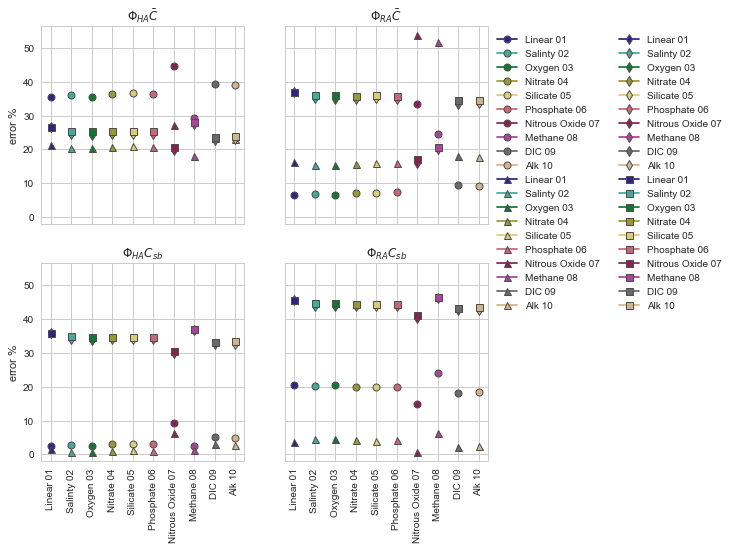

In [115]:
fig, ((ax,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(8,8), sharex=True, sharey=True)

exp_folders = ['UPW_10TR_BF2_AST','UPW_10TR_BF2_AST','UPW_10TR_BF2_KV3D_AST','UPW_10TR_BF2_KV3D_AST']
exps = ['UPW_10TR_BF2_AST_01','UPW_10TR_BF2_AST_03','UPW_10TR_BF2_KV3D_AST_01','UPW_10TR_BF2_KV3D_AST_02']
markers=['o','^','d','s']

for uu, nn, ff, phi, kcan, kbg, epsilon, run_lab, fold, exp, mark in zip(U, N, f, Phi_model, kcans, kbgs, epsilons,
                                                                         run_labels, exp_folders, exps, markers):
    ii = 0
    for key, col, lab, C in zip(tracers, colours, labels, sb_conc_A):
    
        # --- get Phi_tr ----
        filename = ('/data/kramosmu/results/TracerExperiments/%s/HCW_TrMass_%s_%s.csv' %(fold,key,exp))
        df = pd.read_csv(filename)
        HCW = 1000*df['HCW'][:] # *1000 to go from m^3/s to L/s

        if (key == 'Tr07' or key == 'Tr08'):
            TrMass = df['TrMassHCW'][:]
        else:
            TrMass = df['TrMassHCW'][:]*1E3

        PhiTr = np.mean(np.array([(TrMass[ii]-TrMass[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
        PhiTr_std = np.std(np.array([(TrMass[ii]-TrMass[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
        # --- ---------- ----

        # --- calculate \bar{C} ----------
        Zdif = ((kcan-kbg)*t*3600*24)**0.5
        dk =(kcan-kbg)

        Dz = 5 #abs(ZA[int(Hrim/5)+1]-ZA[int(Hrim/5)-1])
        Z = ((ff*uu*F(Ro(uu,ff,R))*L)**(0.5))/nn

        Sdif_min = np.exp(-0.15*Zdif/5)
        Sdif_max = (Zdif/Dz)*np.exp(-(kcan*t*3600*24)/((epsilon)**2))
        S_max = (Z/Hh)*np.exp(-kcan*t*3600*24/Z**2)
        S_min = (Z/Hh)*np.exp(-kbg*t*3600*24/Z**2)

        A_4 = 0.33
        B_4 = 0.06
        C_4 = 1.0

        c_be_0 = 2.72
        c_be_1 = 2.19
        c_be_2 =-1.13

        c_ab_0 = 7.35
        c_ab_1 = 0.21
        c_ab_2 = 0.82

        C_bar = (A_4*S_max+B_4*Sdif_max+C_4)*C
        Nbe_scaled =  np.sqrt(c_be_0*S_min +c_be_1*(1-Sdif_min) +c_be_2)*nn
        Nab_scaled =  np.sqrt(c_ab_0*S_max + c_ab_1*Sdif_max + c_ab_2)*nn

        if  (c_be_0*S_min +c_be_1*(1-Sdif_min) +c_be_2)< 0 :
            N_eff_scaled = (0.75*Nab_scaled)
        else:
            N_eff_scaled = (0.75*Nab_scaled + 0.25*Nbe_scaled) 

        Se = SE(s, nn, ff, F(Ro(uu,ff,Wiso)), Ro(uu,ff,L))
        HA2013=1000*((slope*(F(Ro(uu,ff,Wiso))**(3/2))*(Ro(uu,ff,L)**(1/2))*((1-param*Se)**3))+intercept)*(uu*Wiso*Dh(ff,L,nn))
        RA2019 = 1000*(((slope2*(F(Ro(uu,ff,Wiso))**(3/2))*(Ro(uu,ff,L)**(1/2))*((1-param2*Se)**3))+intercept2)*
                       (uu*Wiso*Dh(ff,L,N_eff_scaled)))
 
        ax.errorbar(ii,100*abs(((HA2013*C_bar)-PhiTr)/PhiTr), marker=mark, c=col, label=lab, mec='0.3',mew=1 )
        ax2.errorbar(ii,100*abs(((1.01*RA2019*C_bar+551000)-PhiTr)/PhiTr), marker=mark, c=col, label=lab, mec='0.3',mew=1)
        ax3.errorbar(ii,100*abs(((HA2013*C)-PhiTr)/PhiTr), marker=mark, c=col, label=lab, mec='0.3',mew=1)
        ax4.errorbar(ii,100*abs(((RA2019*C)-PhiTr)/PhiTr), marker=mark, c=col, label=lab, mec='0.3',mew=1)  
        ii =ii+1
    
ax.set_ylabel(r'error $\%$')
ax.set_title(r'$\Phi_{HA} \bar{C}$')
ax2.set_title(r'$\Phi_{RA} \bar{C}$')
ax3.set_ylabel(r'error $\%$')
ax3.set_title(r'$\Phi_{HA} C_{sb}$')
ax4.set_title(r'$\Phi_{RA} C_{sb}$')
ax3.set_xticks([0,1,2,3,4,5,6,7,8,9])
ax3.set_xticklabels(labels,rotation=90)
ax4.set_xticklabels(labels,rotation=90)

ax2.legend(bbox_to_anchor=(1,1), ncol=2)


circles: Astoria, 

triangles: ARGO, 

diamonds: step Kv=$10^{-2}$m$^2$s$^{-1}$, 

squares: $\epsilon$=25 m Kv=$10^{-2}$m$^2$s$^{-1}$

N from ARGO - Use N mean in scalings above beacuse N is not uniform for a depth Z.

+-----------+----------------+
| Depth / m | $N$ / $s^{-1}$ |
+-----------+----------------+
|   -7.50   |    0.00019     |
|   -12.50  |    0.00216     |
|   -17.50  |    0.01644     |
|   -22.50  |    0.02719     |
|   -27.50  |    0.02268     |
|   -32.50  |    0.00725     |
|   -37.50  |    0.01299     |
|   -42.50  |    0.01481     |
|   -47.50  |    0.00798     |
|   -52.50  |    0.00161     |
|   -57.50  |    0.00990     |
|   -62.50  |    0.01633     |
|   -67.50  |    0.02218     |
|   -72.50  |    0.02522     |
|   -77.50  |    0.01835     |
|   -82.50  |    0.00643     |
|   -87.50  |    0.00757     |
|   -92.50  |    0.00900     |
|   -97.50  |    0.00989     |
|  -102.50  |    0.01066     |
|  -107.50  |    0.01203     |
|  -112.50  |    0.01290     |
|  -117.50  |    0.01153     |
|  -122.50  |    0.01021     |
|  -127.50  |    0.01026     |
|  -132.50  |    0.01028     |
|  -137.50  |    0.00957     |
|  -142.50  |    0.00871     |
|  -147.50  |    0.00739     |
|  -152.

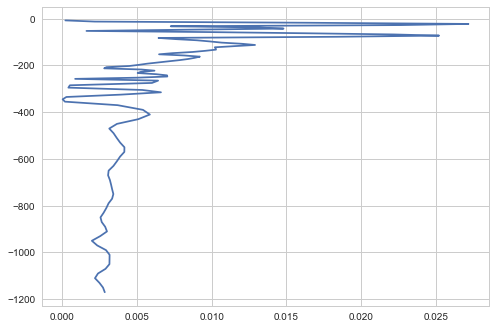

In [42]:
state_fileARGO = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/03_Ast03_Argo/stateGlob.nc'
state_argo = xr.open_dataset(state_fileARGO)
density = call_rho(1,state_argo,slice(0,104),180,20)
N_argo = np.sqrt((g/RhoRef)*((density.data[2:]-density.data[:-2])/(-ZA[2:]+ZA[:-2])) )

plt.plot(N_argo,ZA[1:-1])

from prettytable import PrettyTable
tab = PrettyTable(['Depth / m', '$N$ / $s^{-1}$'])

for ii in range(0,len(ZA[:])-2):
    tab.add_row(['%1.2f' %ZA[ii+1],'%1.5f' %(N_argo[ii])])

print(tab)

N_mean = np.mean(N_argo[20:20+10])
print(N_mean)